# The Notebook where Everything happens

In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as f
from tqdm import tqdm


from networks.upscaler_small_backbone import UpscalerResNet
from networks.upscaler_small_backbone_dropout import UpscalerResNet as UpscalerDropout
from networks.upscaler_small_backbone_batchnorm import UpscalerResNet as UpscalerBatchnorm
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import MSELoss
from torch.nn import L1Loss

from data.memory_dataset import MemoryData
from data.ssd_dataset import SSDData
from data.random_position_selector import RandomPartSelector
from data.same_position_selector import SamePartSelector
import torchvision.transforms.v2 as transforms

from networks.trainer import train, train_feature_reconstruction

Image.MAX_IMAGE_PIXELS = None

%load_ext autoreload
%autoreload 2

### Defining transformations and Device

In [2]:
train_transform = transforms.Compose([RandomPartSelector(minimum_size=512, output_size=512),])
val_transform = SamePartSelector(output_size=512)
device = "cuda"

### Defining model parameters

In [3]:
hp = {
    "num_blocks" : 5,
    "backbone_dimension" : 192,
    "layer_dim" : [96, 96, 96, 96, 96, 96, 96, 96, 96, 96],
    "depth" : 7
}

model = UpscalerResNet(hp)
model.parameter_report()
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
train_losses = []
val_losses = []

/home/daniel/anaconda3/envs/i2dl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/anaconda3/envs/i2dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


74208 parameters in reshape filters
996480 parameters in decoder blocks
683715 parameters in upscaler


### Defining data sets and loaders

In [4]:
batch_size=1

val_set = SSDData(["data/valued/downloaded"], val_transform, start=0, size=97)
train_set = SSDData(["data/valued/downloaded"], train_transform, 0, 2200)

train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size)

2297
2297


In [5]:
optimizer.lr=2e-6
train_feature_reconstruction(model, optimizer, 2, train_loader, val_loader, train_losses, val_losses, 100, 96)

/home/daniel/anaconda3/envs/i2dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val 00002: 100%|███████████████████████████████████| 97/97 [00:16<00:00,  5.91it/s, loss=0.02685090]


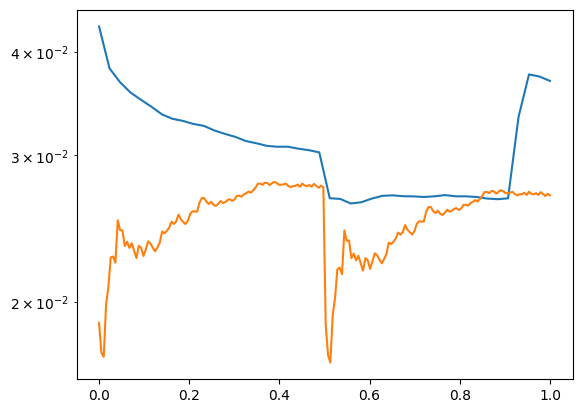

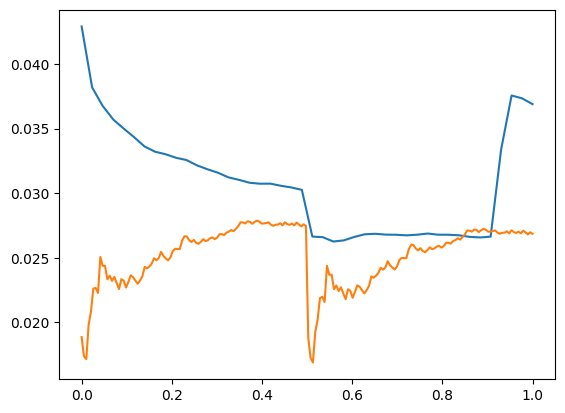

In [6]:
from visualization_tools import plot_upscaling, plot_loss_curves

plot_loss_curves(train_losses, val_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


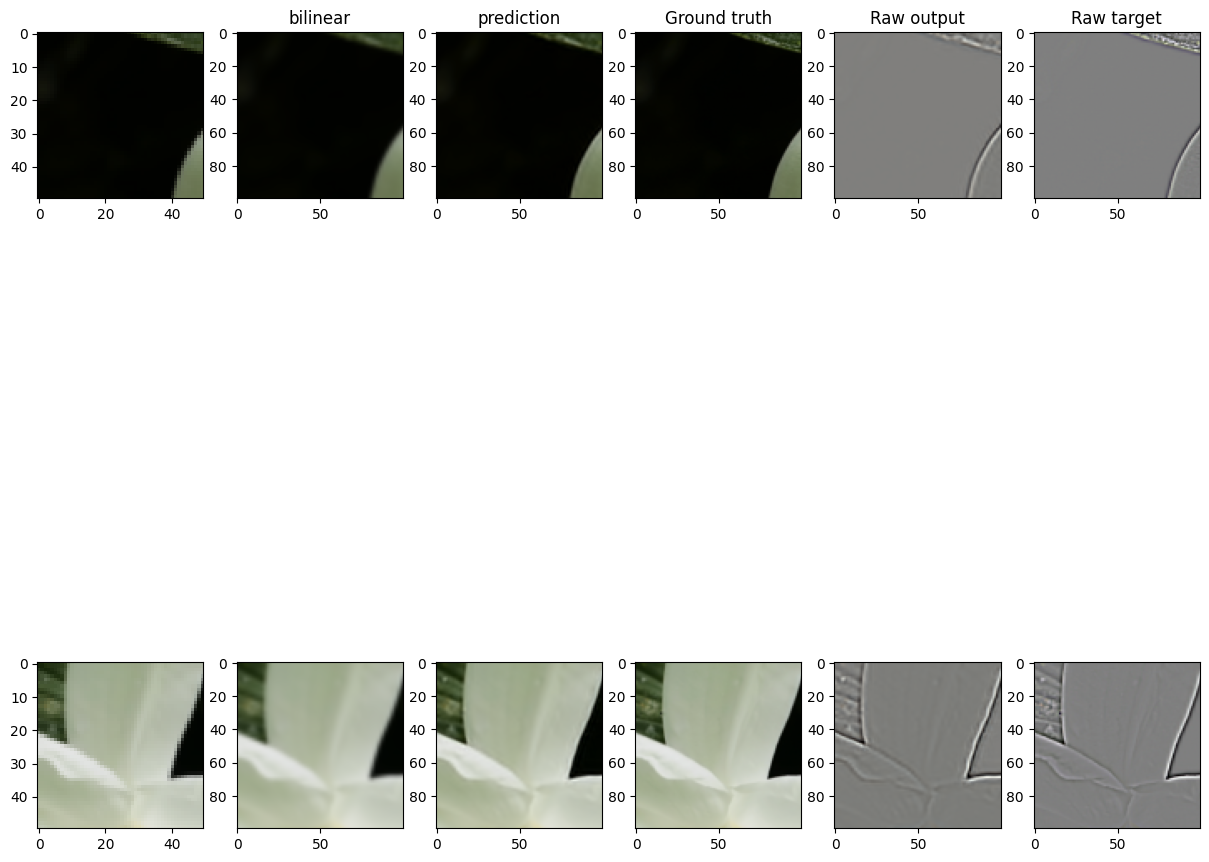

In [9]:

import random
import torchvision.transforms.v2 as transforms

train_pair = train_set[random.randint(0, len(train_set) - 1)]

val_pair = val_set[random.randint(0, len(val_set) - 1)]

plot_upscaling(val_pair, model)

In [ ]:
demo_transform = SamePartSelector(output_size=1024)
demo_set = SSDData(["data/valued/downloaded"], demo_transform, start=0, size=97)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


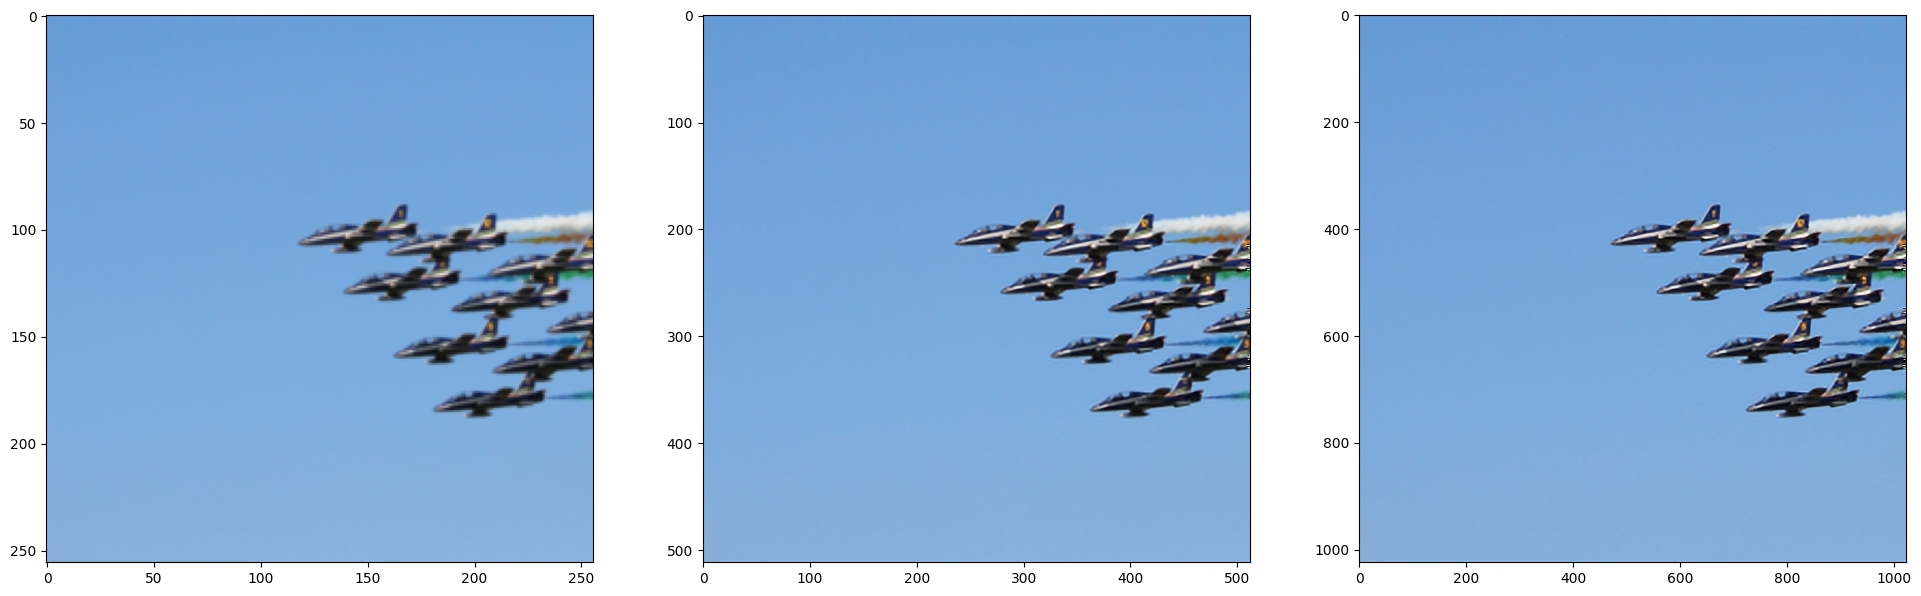

In [221]:
from visualization_tools import show_multi_resolution

# no problem in range 30-2458
val_loader = DataLoader(val_set, batch_size)


val_pair = val_set[2]

show_multi_resolution(val_pair, model)

In [60]:
torch.save(model, "Perspective_Pretrained_backbone_2M.pt")